In [191]:
class Matrix:
    pass
class Vector:
    pass

class Matrix:
    def __init__(self, data):
        self.data = data
        self.m = len(data)          #rows
        self.n = len(data[0])       #cols

    def shape(self) -> tuple[int, int]:
        return self.m, self.n
    
    def T(self) -> Matrix:
        return Matrix([[self.data[j][i] for j in range(self.m)] for i in range(self.n)])

    def __str__(self) -> str:
        max_item_size = 0
        for row in self.data:
            for item in row:
                max_item_size = max(max_item_size, len(str(item)))
        def min_str(item):
            string = str(item)
            delta = max_item_size - len(string)
            left = delta // 2
            return (" " * left) + str(item) + (" " * (delta - left))
        return '\n'.join(["|| " + (" ".join(map(min_str, row))) + " ||" for row in self.data])

    def __repr__(self) -> str:
        return f"Matrix({self.m}x{self.n})"

    def __add__(self, other : Matrix) -> Matrix:
        if isinstance(other, Matrix) and self.shape() == other.shape():
            return Matrix([[self.data[i][j] + other.data[i][j] for j in range(self.n)] for i in range(self.m)])
        else:
            raise ValueError("matrix add/sub error")
        
    def __mul__(self, other : Matrix | float) -> Matrix:
        if isinstance(other, Matrix):
            if self.n != other.m:
                raise ValueError("bad dimensions")
            return Matrix([[sum(self.data[i][k] * other.data[k][j] for k in range(self.n)) 
                      for j in range(other.n)] for i in range(self.m)])
        elif isinstance(other, (int, float)):
            return Matrix([[self.data[i][j] * other for j in range(self.n)] for i in range(self.m)])
        else:
            raise ValueError("unsupported operand for matrix multiplication")
        
    def __rmul__(self, other : Matrix | float) -> Matrix:
        return self * other
        
    def __sub__(self, other : Matrix) -> Matrix:
        return self + other * (-1)
    
    def __neg__(self) -> Matrix:
        return self * (-1)
    
    def __matmul__(self, other : Matrix) -> Matrix:
        if isinstance(other, Matrix):
            if self.shape() != other.shape():
                raise ValueError("bad shapes in Hadamard product")
            return Matrix([[self[i, j] * other[i, j] for j in range(self.n)] for i in range(self.m)])
        else:
            raise ValueError("unsupported operand for Hadamard product")
        
    def __rmatmul__(self, other : Matrix) -> Matrix:
        return self @ other

    def __eq__(self, other : Matrix) -> bool:
        if not isinstance(other, Matrix):
            return False
        return self.data == other.data
    
    def is_square(self) -> bool:
        return self.m == self.n
    
    def minor(self, row, col) -> Matrix:
        return Matrix([self.data[i][:col] + self.data[i][col + 1:] for i in range(self.m) if i != row])
    
    def det(self) -> float:
        if not self.is_square():
            raise ValueError("attempt to get determinant of not square matrix")
        if self.m == 1:
            return self.data[0][0]
        if self.m == 2:
            return self.data[0][0] * self.data[1][1] - self.data[0][1] * self.data[1][0]
        det = 0
        for c in range(self.m):
            det += ((-1) ** c) * self.data[0][c] * self.minor(0, c).det()
        return det

    def tr(self) -> float:
        if not self.is_square():
            raise ValueError("attempt to get trace of not square matrix")
        trace = 0
        for i in range(self.n):
            trace += self.data[i][i]
        return trace
    
    def copy(self) -> Matrix:
        return Matrix([[item for item in row] for row in self.data])
    
    def __getitem__(self, index : int | tuple[int, int]) -> float:
        if isinstance(index, tuple) and len(index) == 2:
            row, col = index
            return self.data[row][col]
        elif isinstance(index, int):
            if self.n != 1:
                raise IndexError("this indexation method is used for Vectors")
            return self.data[index][0]
        else:
            raise IndexError("invalid matrix index")
    
    def __setitem__(self, index : int | tuple[int, int], value : float) -> None:
        if isinstance(index, tuple) and len(index) == 2:
            row, col = index
            self.data[row][col] = value
        elif isinstance(index, int):
            if self.n != 1:
                raise IndexError("this indexation method is used for Vectors")
            self.data[index][0] = value
        else:
            raise IndexError("invalid matrix index")
        
    def expand(self, f : Vector) -> Matrix:
        return Matrix([row + [f[i]] for i, row in enumerate(self.data)])
    
    def zeros(m : int, n : int) -> Matrix:
        return Matrix([[0 for j in range(n)] for i in range(m)])

class Vector(Matrix):
    def __init__(self, data):
        super().__init__([[item] for item in data])

    def zeros(size : int):
        return Vector([0 for i in range(size)])

def det(A : Matrix):
    return A.det()

def tr(A : Matrix):
    return A.tr()

def get_max_norm(A : Matrix):
    return max([max([abs(A[i, j]) for i in range(A.m)]) for j in range(A.n)])

def get_Manhattan_norm(A : Matrix):
    return sum([sum([abs(A[i, j]) for i in range(A.m)]) for j in range(A.n)])

def get_Euclidian_norm(A : Matrix):
    return sum([sum([A[i, j]*A[i, j] for i in range(A.m)]) for j in range(A.n)]) ** 0.5

def get_induced_max_norm(A : Matrix):
    return max([sum([abs(A[i, j]) for j in range(A.n)]) for i in range(A.m)])

def get_induced_Manhattan_norm(A : Matrix):
    return max([sum([abs(A[i, j]) for i in range(A.m)]) for j in range(A.n)])

## residual plots

In [192]:
from matplotlib import pyplot as plt

plot_x_points = []
plot_y_points = []

def add_residual_point(x, y):
    global plot_x_points
    global plot_y_points
    plot_x_points += [x]
    plot_y_points += [y]

def show_residual_plot():
    global plot_x_points
    global plot_y_points
    if(len(plot_x_points) == 0) or (len(plot_x_points) != len(plot_y_points)):
        return
    plt.plot(plot_x_points, plot_y_points)
    plt.xlabel("iteration")
    plt.xlabel("residual")
    plt.yscale("log")
    plt.show()
    print("iteration count:", len(plot_x_points))
    plot_x_points.clear()
    plot_y_points.clear()

## Matrix and other settings

In [193]:
A = Matrix([[2, 3, -1], [4, 1, 2], [-3, 2, 1]])
f = Vector([9, 4, 0])
zero_eps = 1e-15    #for zero checking
eps = 1e-15         #residual for iterational methods
w_SOR = 3/2         #parameter for SOR method

print("|A| =", det(A))

norm = get_Euclidian_norm

def show_result(x : Vector):
    print("solution: ", x, "\nright part:", A*x, sep="\n")
    show_residual_plot()

|A| = -47


## Gauss with pivot

In [194]:
def argmax(iterable) -> int:
    max_index = 0
    max_item = iterable[0]
    for index, item in enumerate(iterable):
        if item > max_item:
            max_index = index
            max_item = item
    return max_index

def find_solution_by_Gauss(A : Matrix, f : Vector) -> Vector:
    Af = A.expand(f)
    n = A.n
    for j in range(n):
        pivot = argmax([abs(Af[k, j]) for k in range(j, n)]) + j
        if abs(Af[pivot, j]) < zero_eps:
            raise ValueError("singular matrix")
        Af.data[pivot], Af.data[j] = Af.data[j], Af.data[pivot]
        for i in range(j + 1, n):
            factor = Af[i, j] / Af[j, j]
            for k in range(j, n + 1):
                Af[i, k] -= factor * Af[j, k]
    x = Vector.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (Af[i, n] - sum([Af[i, j] * x[j] for j in range(i + 1, n)])) / Af[i, i]
    return x

x = find_solution_by_Gauss(A, f)
show_result(x)

solution: 
||         1.0         ||
||         2.0         ||
|| -1.0000000000000002 ||

right part:
||          9.0           ||
||   3.9999999999999996   ||
|| -2.220446049250313e-16 ||


## LU decomposition

In [195]:
def get_LU_decomposition(A : Matrix) -> tuple[Matrix, Matrix]:
    n = A.n
    L = Matrix.zeros(n, n)
    U = Matrix.zeros(n, n)
    
    for i in range(n):
        for j in range(i, n):
            U[i, j] = A[i, j] - sum(L[i, k] * U[k, j] for k in range(i))
        for j in range(i, n):
            if i == j:
                L[i, i] = 1
            else:
                L[j, i] = (A[j, i] - sum(L[j, k] * U[k, i] for k in range(i))) / U[i, i]
    return L, U

def find_solution_by_LU(A : Matrix, f : Vector) -> Vector:
    n = A.n
    L, U = get_LU_decomposition(A)
    x = Vector.zeros(n)
    y = Vector.zeros(n)
    for i in range(n):
        y[i] = (f[i] - sum([L[i, j] * y[j] for j in range(i)]))
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - sum([U[i, j] * x[j] for j in range(i + 1, n)])) / U[i, i]
    return x

L, U = get_LU_decomposition(A)
print("L:", L, "\nU:", U, sep="\n")
print()
x = find_solution_by_LU(A, f)
show_result(x)

L:
||  1    0    0   ||
|| 2.0   1    0   ||
|| -1.5 -1.3  1   ||

U:
||  2    3    -1  ||
||  0   -5.0 4.0  ||
||  0    0   4.7  ||

solution: 
||         1.0         ||
||         2.0         ||
|| -0.9999999999999998 ||

right part:
||          9.0          ||
||          4.0          ||
|| 2.220446049250313e-16 ||


## Jacobi

In [196]:
def find_solution_by_Jacobi(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    n = A.shape()[0]
    x = x0.copy()
    x_dual = Vector.zeros(n)
    while norm(A * x - f) > eps:
        for i in range(n):
            x_dual[i] = (-sum([A[i, j] * x[j] for j in range(n) if i != j]) + f[i]) / A[i, i]
        x, x_dual = x_dual, x
    return x

x = find_solution_by_Jacobi(A, f, Vector.zeros(A.n))
show_result(x)

solution: 
|| inf  ||
|| -inf ||
|| inf  ||

right part:
|| nan ||
|| nan ||
|| nan ||


## Seidel

solution: 
|| 1.0  ||
|| 2.0  ||
|| -1.0 ||

right part:
|| 9.0 ||
|| 4.0 ||
|| 0.0 ||


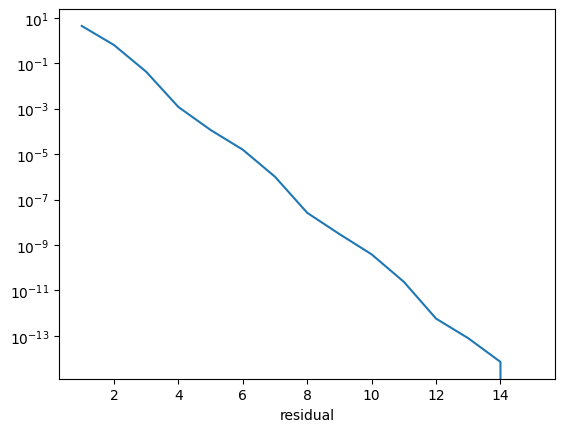

iteration count: 15


In [197]:
def find_solution_by_Seidel(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    n = A.n
    x = x0.copy()
    x_dual = Vector.zeros(n)
    iteration = 0
    while norm(A * x - f) > eps:
        for i in range(n):
            x_dual[i] = -(sum([A[i, j] * x_dual[j] for j in range(i) if i != j]) 
                          + sum([A[i, j] * x[j] for j in range(i+1, n) if i != j]) 
                          - f[i]) / A[i, i]
        x, x_dual = x_dual, x
        iteration += 1
        add_residual_point(iteration, norm(A * x - f))
    return x

x = find_solution_by_Seidel(A, f, Vector.zeros(A.n))
show_result(x)

## successive over-relaxation

solution: 
|| 1.0  ||
|| 2.0  ||
|| -1.0 ||

right part:
|| 9.0 ||
|| 4.0 ||
|| 0.0 ||


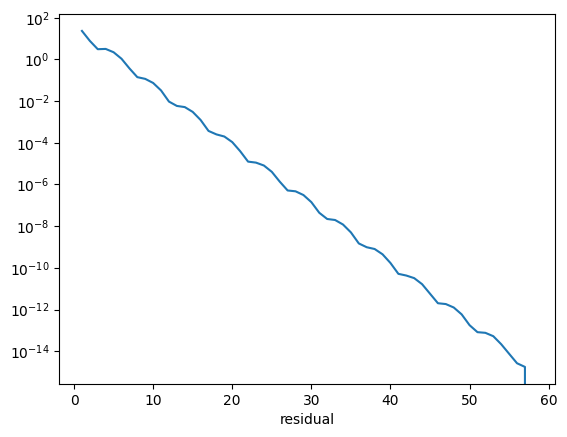

iteration count: 58


In [203]:
def find_solution_by_SOR(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    n = A.n
    x = x0.copy()
    x_dual = Vector.zeros(n)
    iteration = 0
    while norm(A * x - f) > eps:
        for i in range(n):
            x_dual[i] = (1 - w_SOR) * x[i] - w_SOR * (sum([A[i, j] * x_dual[j] for j in range(i) if i != j]) 
                          + sum([A[i, j] * x[j] for j in range(i+1, n) if i != j]) - f[i]) / A[i, i]
        x, x_dual = x_dual, x
        iteration += 1
        add_residual_point(iteration, norm(A * x - f))
    return x

x = find_solution_by_SOR(A, f, Vector.zeros(A.n))
show_result(x)

## gradient descent

solution: 
|| 0.9999999999999999 ||
||        2.0         ||
||        -1.0        ||

right part:
||          9.0          ||
||  3.9999999999999996   ||
|| 4.440892098500626e-16 ||


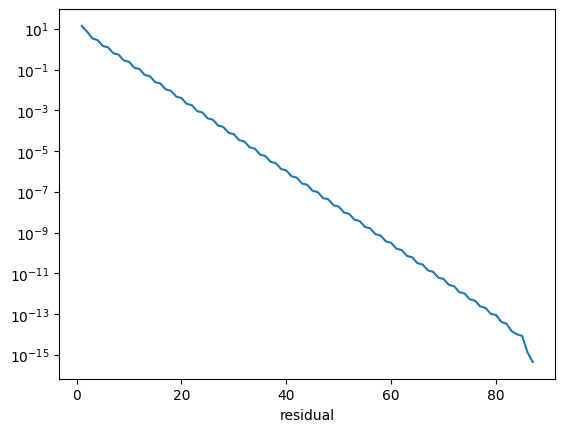

iteration count: 87


In [204]:
def find_solution_by_gradient_descent(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    x = x0
    residual = A * x - f
    iteration = 0
    while norm(residual) > eps:
        tau = (residual.T() * residual)[0] / ((A * residual).T() * residual)[0]
        x -= tau * residual
        residual = A * x - f
        iteration += 1
        add_residual_point(iteration, norm(A * x - f))
    return x

x = find_solution_by_gradient_descent(A, f, Vector.zeros(A.n))
show_result(x)

## minimal residual method

solution: 
|| 1.0  ||
|| 2.0  ||
|| -1.0 ||

right part:
|| 9.0 ||
|| 4.0 ||
|| 0.0 ||


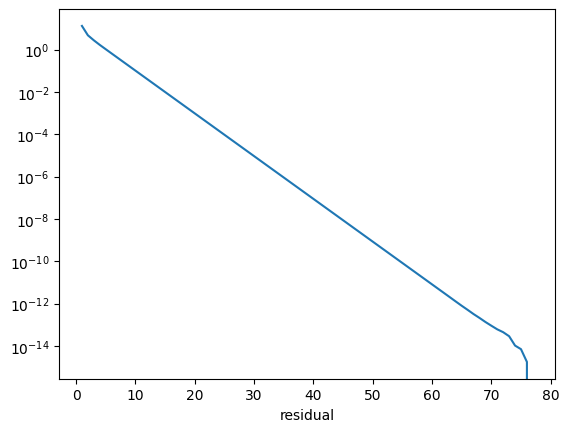

iteration count: 77


In [205]:
def find_solution_by_minimal_residual(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    x = x0
    residual = A * x - f
    iteration = 0
    while norm(residual) > eps:
        Ar = A * residual
        tau = (Ar.T() * residual)[0] / (Ar.T() * Ar)[0]
        x -= tau * residual
        residual = A * x - f
        iteration += 1
        add_residual_point(iteration, norm(A * x - f))
    return x

x = find_solution_by_minimal_residual(A, f, Vector.zeros(A.n))
show_result(x)

## conjugate gradient method

solution: 
|| 0.9999999999999998 ||
|| 1.9999999999999996 ||
||        -1.0        ||

right part:
|| 8.999999999999998  ||
|| 3.9999999999999987 ||
||        0.0         ||


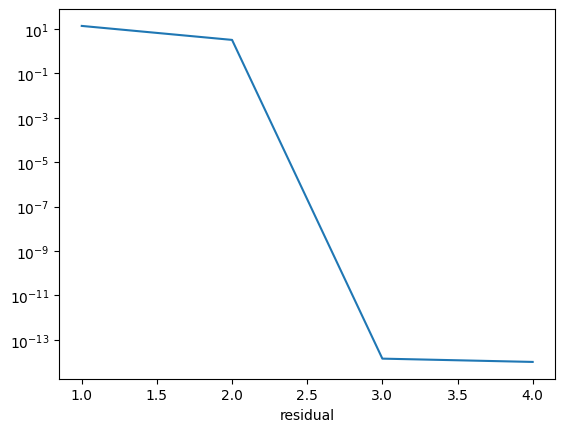

iteration count: 4


In [206]:
def find_solution_by_CG(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    x = x0
    residual = A * x - f
    direction = residual.copy()
    r2_old = (residual.T() * residual)[0]
    iteration = 0
    while norm(residual) > eps:
        Ad = A * direction
        alpha = r2_old / (direction.T() * Ad)[0]
        x -= alpha * direction
        residual -= alpha * Ad
        r2_new = (residual.T() * residual)[0]
        direction = residual + (r2_new / r2_old) * direction
        r2_old = r2_new
        iteration += 1
        add_residual_point(iteration, norm(A * x - f))
    return x

x = find_solution_by_CG(A, f, Vector.zeros(A.n))
show_result(x)

## BiCGStab

solution: 
|| 0.9999999999999996  ||
|| 2.0000000000000013  ||
|| -0.9999999999999989 ||

right part:
||  9.000000000000002   ||
||  4.000000000000002   ||
|| 5.10702591327572e-15 ||


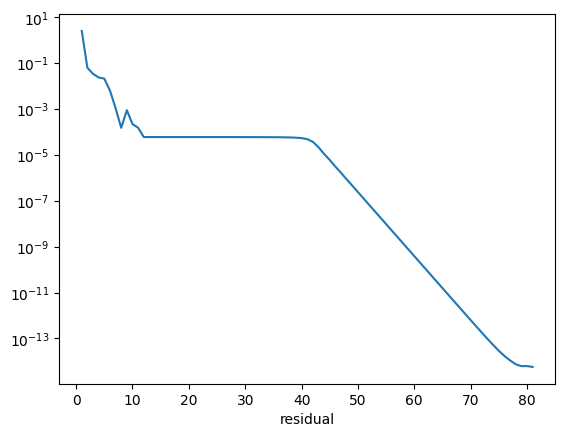

iteration count: 81


In [210]:
def find_solution_by_BiCGStab(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    x = x0
    residualX = A * x - f
    r0 = residualX.T()
    directionX = Vector.zeros(A.n)
    residualY = Vector.zeros(A.n)
    rho_old = 1
    alpha = 1
    omega = 1
    iteration = 0
    while norm(residualX) > eps:
        rho = (r0 * residualX)[0]
        if abs(rho) < zero_eps:
            raise ValueError("BiCGStab can't solve this system")
        beta = rho / rho_old * alpha / omega
        directionX = residualX + beta * (directionX - omega * residualY)
        residualY = A * directionX
        alpha = rho / (r0 * residualY)[0]
        directionY = residualX - alpha * residualY
        Ady = A * directionY
        omega = (Ady.T() * directionY)[0] / (Ady.T() * Ady)[0]
        x -= alpha * directionX + omega * directionY
        residualX = directionY - omega * Ady
        iteration += 1
        add_residual_point(iteration, norm(A * x - f))
    return x

x = find_solution_by_BiCGStab(A, f, Vector.zeros(A.n))
show_result(x)

BiCGStab with $A = A^T > 0$

solution: 
|| 1.0000000000000002  ||
||         2.0         ||
|| -0.9999999999999998 ||

right part:
||          9.0           ||
||   4.000000000000002    ||
|| -6.661338147750939e-16 ||


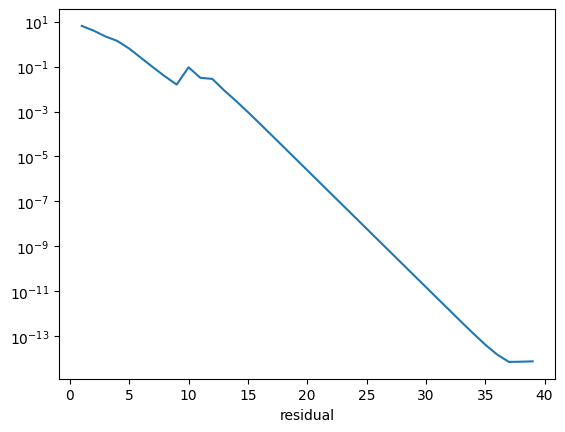

iteration count: 39


In [211]:
x = find_solution_by_BiCGStab(A.T() * A, A.T() * f, Vector.zeros(A.n))
show_result(x)